In [3]:
import vis
import json
from vis.utils import utils
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from vis.visualization import visualize_saliency
from keras.models import load_model
import pathlib
import numpy as np
%matplotlib inline

In [182]:
# _img = load_img('tiny-imagenet-200/train/n01641577/images/n01641577_10.JPEG')
_img = load_img('./data/tiny-imagenet-200/b_train/n01641577/images/n01641577_108bb.JPEG',target_size=(128,128,3))

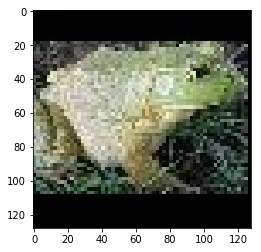

In [183]:
plt.imshow(_img)
plt.show()

In [184]:
model = tf.keras.models.load_model('./models/incep3.h5')

In [185]:
# Create a tensorflow dataset
data_dir = pathlib.Path('./data/tiny-imagenet-200/train/')
val_data_dir = pathlib.Path('./data/tiny-imagenet-200/validation/')

image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
val_names = np.array([item.name for item in val_data_dir.glob('*')])
CLASS_NAMES==val_names

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [186]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [187]:
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(CLASS_NAMES))
val_data_gen = image_generator.flow_from_directory(directory=str(val_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes=list(val_names))

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [188]:
val_data_gen.class_indices == train_data_gen.class_indices

True

In [189]:
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
idx2label = {}
for i_dict in range(len(CLASS_INDEX)):
    if CLASS_INDEX[str(i_dict)][0] in CLASS_NAMES:
        idx2label[CLASS_INDEX[str(i_dict)][0]] = CLASS_INDEX[str(i_dict)][1]

In [190]:
val_data_gen.class_indices['n03804744']

122

In [191]:
classlabels = [(idx2label[cls]) for cls in CLASS_NAMES]
classlabels

['goldfish',
 'European_fire_salamander',
 'bullfrog',
 'tailed_frog',
 'American_alligator',
 'boa_constrictor',
 'trilobite',
 'scorpion',
 'black_widow',
 'tarantula',
 'centipede',
 'goose',
 'koala',
 'jellyfish',
 'brain_coral',
 'snail',
 'slug',
 'sea_slug',
 'American_lobster',
 'spiny_lobster',
 'black_stork',
 'king_penguin',
 'albatross',
 'dugong',
 'Chihuahua',
 'Yorkshire_terrier',
 'golden_retriever',
 'Labrador_retriever',
 'German_shepherd',
 'standard_poodle',
 'tabby',
 'Persian_cat',
 'Egyptian_cat',
 'cougar',
 'lion',
 'brown_bear',
 'ladybug',
 'fly',
 'bee',
 'grasshopper',
 'walking_stick',
 'cockroach',
 'mantis',
 'dragonfly',
 'monarch',
 'sulphur_butterfly',
 'sea_cucumber',
 'guinea_pig',
 'hog',
 'ox',
 'bison',
 'bighorn',
 'gazelle',
 'Arabian_camel',
 'orangutan',
 'chimpanzee',
 'baboon',
 'African_elephant',
 'lesser_panda',
 'abacus',
 'academic_gown',
 'altar',
 'apron',
 'backpack',
 'bannister',
 'barbershop',
 'barn',
 'barrel',
 'basketball',


In [192]:
class_dict = {}
for i in range(len(CLASS_NAMES)):
    class_dict[CLASS_NAMES[i]] = classlabels[i]

In [193]:
image_data = img_to_array(_img)
preprocessed_image_data = image_data / 255.0
# prediction_probs = model.predict(np.expand_dims(image_data, 0))
prediction_probs = model.predict(np.expand_dims(preprocessed_image_data, 0))

a = prediction_probs[0].argsort()[-5:][::-1]
print(a)

for s in a:
     print(class_dict[CLASS_NAMES[s]], prediction_probs[0][s])

[  2   3  32  30 142]
bullfrog 0.99998236
tailed_frog 0.99829
Egyptian_cat 0.06295885
tabby 0.017305251
rocking_chair 0.006149237


In [196]:
def plot_map(grads, c):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.6f} ".format(
                      classlabels[c],
                      prediction_probs[0][c]))

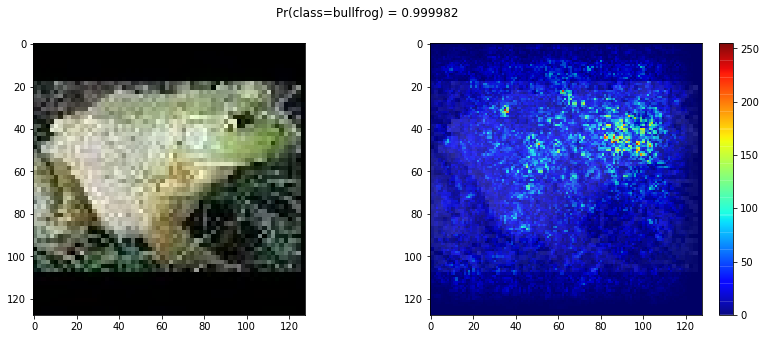

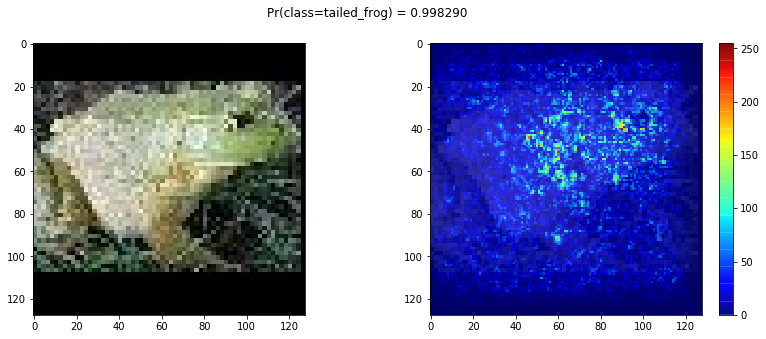

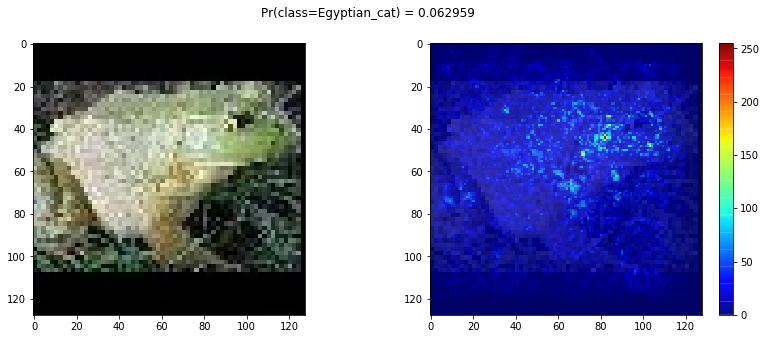

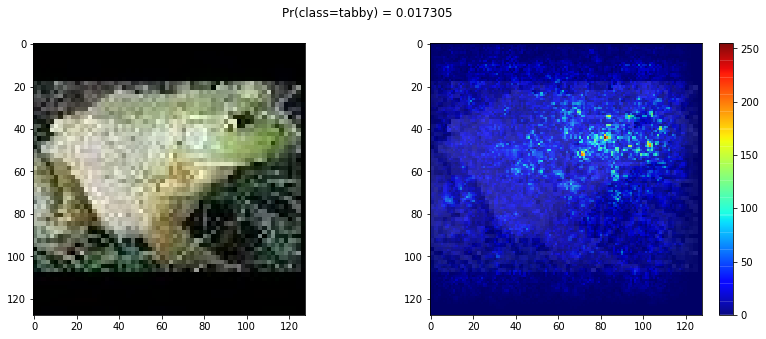

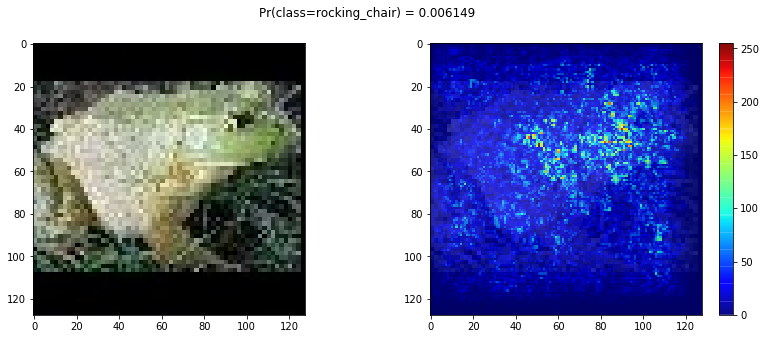

In [197]:
for c in a:
    grad_top1 = visualize_saliency(model,
                               -1,
                               filter_indices = c,
                               seed_input = preprocessed_image_data[np.newaxis])
    plot_map(grad_top1, c)
    plt.show()